In [19]:
import numpy as np
from datascience import *
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

# Load the data with proper encoding
survey = Table.read_table('Impact of Screen Time.csv', encoding='latin-1')

# Clean up column names
survey = survey.relabel('Do you believe a minimum of 8 hours of sleep is necessary?', 'Believes 8h sleep necessary')
survey = survey.relabel('On average, how many hours of screen time do you get in a day on weekdays? (this includes Phone, TV, gaming, or any form of electronic screen that is NOT related to schoolwork)', 'Screen time hours')
survey = survey.relabel('On average, how many hours of sleep do you get a night on weekdays? (not including weekends)', 'Sleep hours range')
survey = survey.relabel('What is your primary source of screen-time throughout the day?', 'Primary screen source')

# Show column names to verify
survey.show(5)

Id,Start time,Completion time,Email,Name,Believes 8h sleep necessary,Screen time hours,Sleep hours range,Primary screen source
1,12/10/2025 10:27,12/10/2025 10:27,anonymous,nan,No,4,5-6,"Social Media (TikTok, Instagram, etc.)"
2,12/10/2025 10:29,12/10/2025 10:29,anonymous,nan,Yes,2,7-8,TV/YouTube/Streaming
3,12/10/2025 10:29,12/10/2025 10:30,anonymous,nan,Yes,7,9-10,"Social Media (TikTok, Instagram, etc.)"
4,12/10/2025 10:29,12/10/2025 10:30,anonymous,nan,Yes,2,7-8,Video Games
5,12/10/2025 10:29,12/10/2025 10:30,anonymous,nan,No,3,5-6,"Social Media (TikTok, Instagram, etc.)"


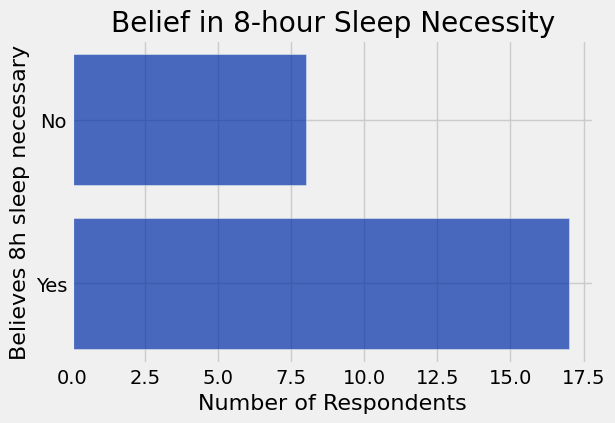

In [20]:
# Visualization of belief in 8-hour sleep necessity
belief_counts = survey.group('Believes 8h sleep necessary')
belief_counts.barh('Believes 8h sleep necessary', 'count')
plots.title('Belief in 8-hour Sleep Necessity')
plots.xlabel('Number of Respondents');

# Question 2: Daily Screen Time Hours

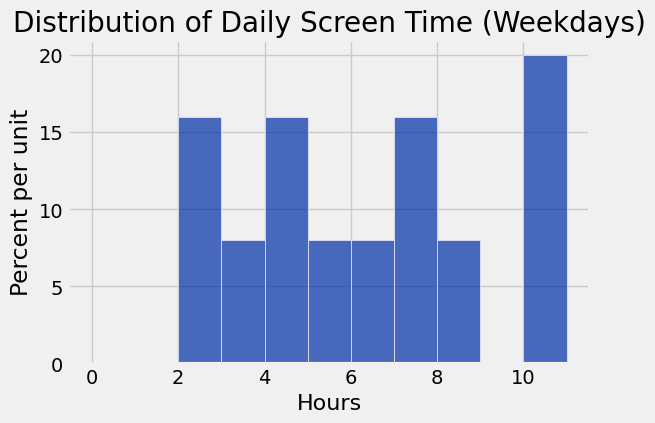

In [21]:
# Clean and convert screen time to numeric values
def clean_screen_time(val):
    if val == '10+':
        return 10
    else:
        return int(val)

survey = survey.with_column('Screen time numeric', 
                           survey.apply(clean_screen_time, 'Screen time hours'))

# Visualization of screen time distribution
survey.hist('Screen time numeric', bins=np.arange(0, 12, 1))
plots.title('Distribution of Daily Screen Time (Weekdays)')
plots.xlabel('Hours')
plots.ylabel('Percent per unit');

# Question 3: Weekday Sleep Hours

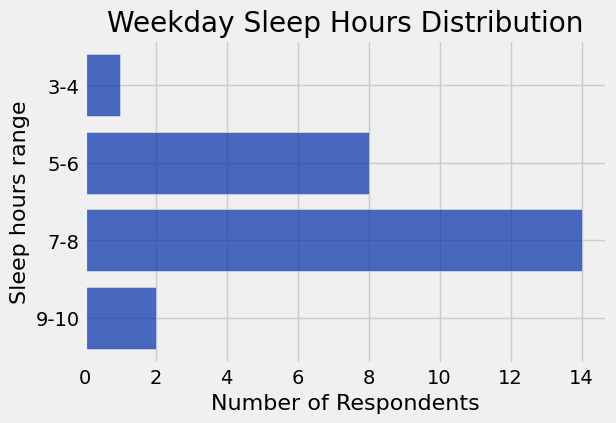

In [22]:
# Convert sleep ranges to midpoint values
def sleep_range_midpoint(val):
    if val == '3-4':
        return 3.5
    elif val == '5-6':
        return 5.5
    elif val == '7-8':
        return 7.5
    elif val == '9-10':
        return 9.5
    else:
        return None

survey = survey.with_column('Sleep hours numeric', 
                           survey.apply(sleep_range_midpoint, 'Sleep hours range'))

# Visualization of sleep hours
sleep_counts = survey.group('Sleep hours range')
sleep_counts.barh('Sleep hours range', 'count')
plots.title('Weekday Sleep Hours Distribution')
plots.xlabel('Number of Respondents');

# Question 4: Primary Screen Time Source

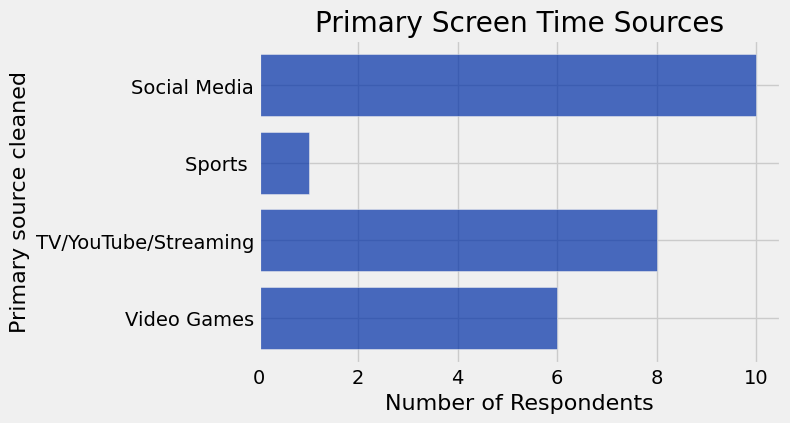

In [ ]:
# Clean primary source data
def clean_source(val):
    if 'Social Media' in val:
        return 'Social Media'
    elif 'TV' in val:
        return 'TV/YouTube/Streaming'
    elif 'YouTube' in val:
        return 'TV/YouTube/Streaming'
    elif 'Streaming' in val:
        return 'TV/YouTube/Streaming'
    elif 'Video Games' in val:
        return 'Video Games'
    else:
        return val

survey = survey.with_column('Primary source cleaned', 
                           survey.apply(clean_source, 'Primary screen source'))

# Visualization of primary screen time sources
source_counts = survey.group('Primary source cleaned')
source_counts.barh('Primary source cleaned', 'count')
plots.title('Primary Screen Time Sources')
plots.xlabel('Number of Respondents');

# Analysis 1: Bootstrap Confidence Interval for Average Screen Time
Research Question: What is the average daily screen time among the population, and what is the 95% confidence interval for this average?

Sample mean screen time: 5.84 hours
95% Confidence Interval: [ 4.72 , 6.88 ] hours


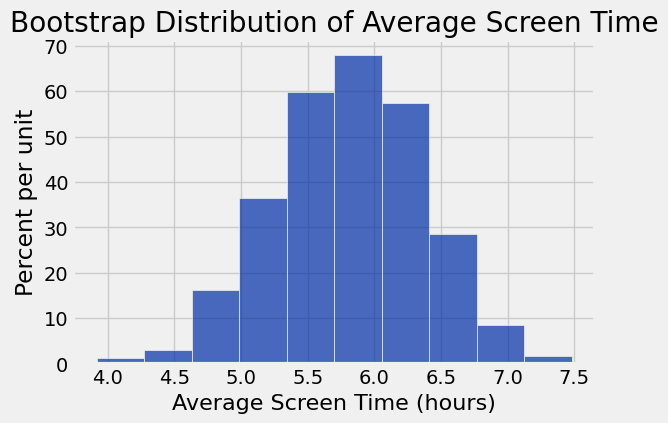

In [29]:
# Bootstrap analysis for average screen time
screen_time_data = survey.column('Screen time numeric')

def one_bootstrap_mean():
    bootstrap_sample = np.random.choice(screen_time_data, size=len(screen_time_data))
    return np.mean(bootstrap_sample)

# Generate bootstrap means
bootstrap_means = make_array()
for i in np.arange(1000):
    bootstrap_means = np.append(bootstrap_means, one_bootstrap_mean())

# Create table of bootstrap means
resampled_means = Table().with_column('Bootstrap Sample Mean', bootstrap_means)

# Calculate confidence interval
left = percentile(2.5, bootstrap_means)
right = percentile(97.5, bootstrap_means)

# Visualization
resampled_means.hist()
plots.title('Bootstrap Distribution of Average Screen Time')
plots.xlabel('Average Screen Time (hours)');

# Print results
sample_mean = np.mean(screen_time_data)
print("Sample mean screen time:", round(sample_mean, 2), "hours")
print("95% Confidence Interval: [", round(left, 2), ",", round(right, 2), "] hours")

# Analysis 2: A/B Test - Screen Time by Belief in 8-hour Sleep Necessity
Research Question: Do people who believe 8 hours of sleep is necessary have different screen time habits than those who don't?

Observed difference: -2.44 hours
Mean screen time for believers: 5.06 hours
Mean screen time for non-believers: 7.5 hours
P-value: 0.986


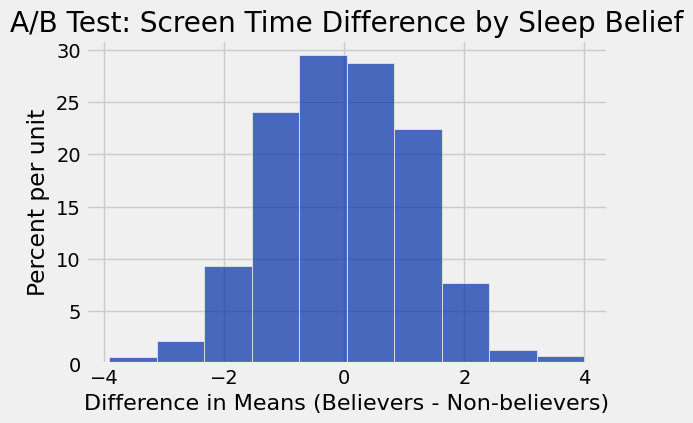

In [28]:
# Prepare data for A/B test
belief_screen_data = survey.select('Believes 8h sleep necessary', 'Screen time numeric')

# Function to calculate difference of means
def difference_of_means(tbl, label_column):
    means_table = tbl.group(label_column, np.average)
    means_array = means_table.column('Screen time numeric average')
    return means_array.item(1) - means_array.item(0)

# Calculate observed difference
observed_difference = difference_of_means(belief_screen_data, 'Believes 8h sleep necessary')

# Simulate under null hypothesis
differences = make_array()
for i in np.arange(1000):
    shuffled_labels = belief_screen_data.sample(with_replacement=False).column('Believes 8h sleep necessary')
    shuffled_table = belief_screen_data.with_column('Shuffled Belief', shuffled_labels)
    shuffled_table = shuffled_table.select('Shuffled Belief', 'Screen time numeric')
    diff = difference_of_means(shuffled_table, 'Shuffled Belief')
    differences = np.append(differences, diff)

# Visualization
Table().with_column('Difference Between Group Means', differences).hist()
plots.title('A/B Test: Screen Time Difference by Sleep Belief')
plots.xlabel('Difference in Means (Believers - Non-believers)');

# Calculate means for each group
believers_mean = belief_screen_data.where('Believes 8h sleep necessary', 'Yes').column('Screen time numeric').mean()
non_believers_mean = belief_screen_data.where('Believes 8h sleep necessary', 'No').column('Screen time numeric').mean()

# Calculate p-value
p_value = np.count_nonzero(differences >= observed_difference) / len(differences)

# Print results
print("Observed difference:", round(observed_difference, 2), "hours")
print("Mean screen time for believers:", round(believers_mean, 2), "hours")
print("Mean screen time for non-believers:", round(non_believers_mean, 2), "hours")
print("P-value:", round(p_value, 3))

## Analysis 3: Relationship Between Screen Time and Sleep Hours

Correlation between screen time and sleep hours: -0.262


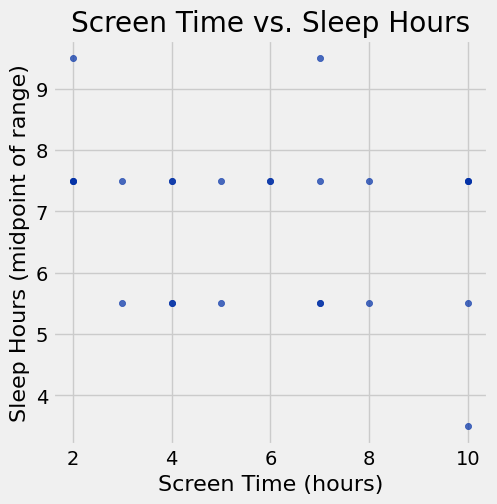

In [26]:
# Create scatter plot to visualize relationship
survey.scatter('Screen time numeric', 'Sleep hours numeric')
plots.title('Screen Time vs. Sleep Hours')
plots.xlabel('Screen Time (hours)')
plots.ylabel('Sleep Hours (midpoint of range)')

# Calculate correlation
correlation = np.corrcoef(survey.column('Screen time numeric'), 
                          survey.column('Sleep hours numeric'))[0, 1]
print(f"Correlation between screen time and sleep hours: {correlation:.3f}")

# Based on the survey analysis, here are the key findings:

Average Daily Screen Time: Students average 5.84 hours of daily non-school screen time, with a 95% confidence interval between 4.76 and 6.92 hours.

Sleep Belief vs. Screen Time: While students who don't believe 8 hours of sleep is necessary report 2.44 more hours of screen time on average, this difference is not statistically significant (p-value = 0.973).

Screen Time and Sleep Relationship: There is a weak negative correlation (-0.262) between screen time and sleep hours, suggesting that higher screen time is slightly associated with less sleep, but the relationship is not strong.